<a href="https://colab.research.google.com/github/DPK-VT/MLTESTS/blob/main/ECBTest4withforecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Index(['Date', 'EUR/USD', 'EUR/JPY', 'EUR/GBP', 'EUR/CHF', 'EUR/AUD'], dtype='object')
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


166/166 - 10s - 59ms/step - loss: 0.0208 - val_loss: 5.1475e-04
Epoch 2/100
166/166 - 10s - 62ms/step - loss: 0.0030 - val_loss: 2.3350e-04
Epoch 3/100
166/166 - 10s - 62ms/step - loss: 0.0024 - val_loss: 3.5253e-04
Epoch 4/100
166/166 - 9s - 57ms/step - loss: 0.0021 - val_loss: 2.2840e-04
Epoch 5/100
166/166 - 10s - 60ms/step - loss: 0.0019 - val_loss: 2.2978e-04
Epoch 6/100
166/166 - 10s - 62ms/step - loss: 0.0018 - val_loss: 1.8389e-04
Epoch 7/100
166/166 - 7s - 43ms/step - loss: 0.0017 - val_loss: 1.6532e-04
Epoch 8/100
166/166 - 11s - 64ms/step - loss: 0.0016 - val_loss: 1.7663e-04
Epoch 9/100
166/166 - 7s - 40ms/step - loss: 0.0015 - val_loss: 1.5321e-04
Epoch 10/100
166/166 - 7s - 44ms/step - loss: 0.0013 - val_loss: 1.7806e-04
Epoch 11/100
166/166 - 10s - 62ms/step - loss: 0.0014 - val_loss: 2.5111e-04
Epoch 12/100
166/166 - 7s - 41ms/step - loss: 0.0013 - val_loss: 1.5003e-04
Epoch 13/100
166/166 - 7s - 43ms/step - loss: 0.0012 - val_loss: 1.3432e-04
Epoch 14/100
166/166 - 10s

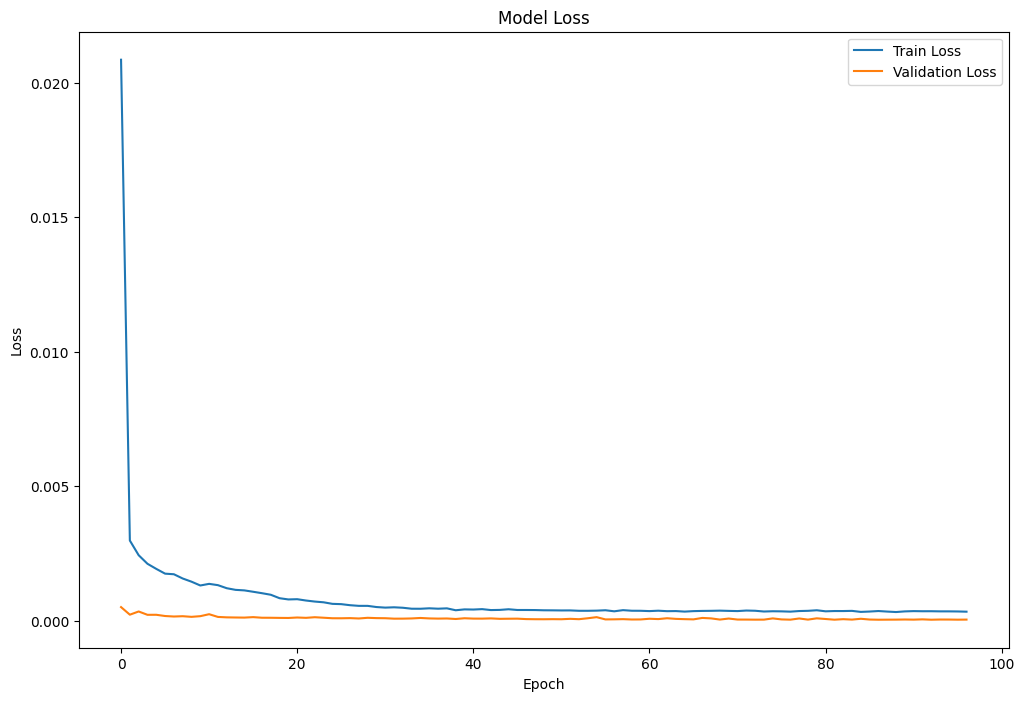

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


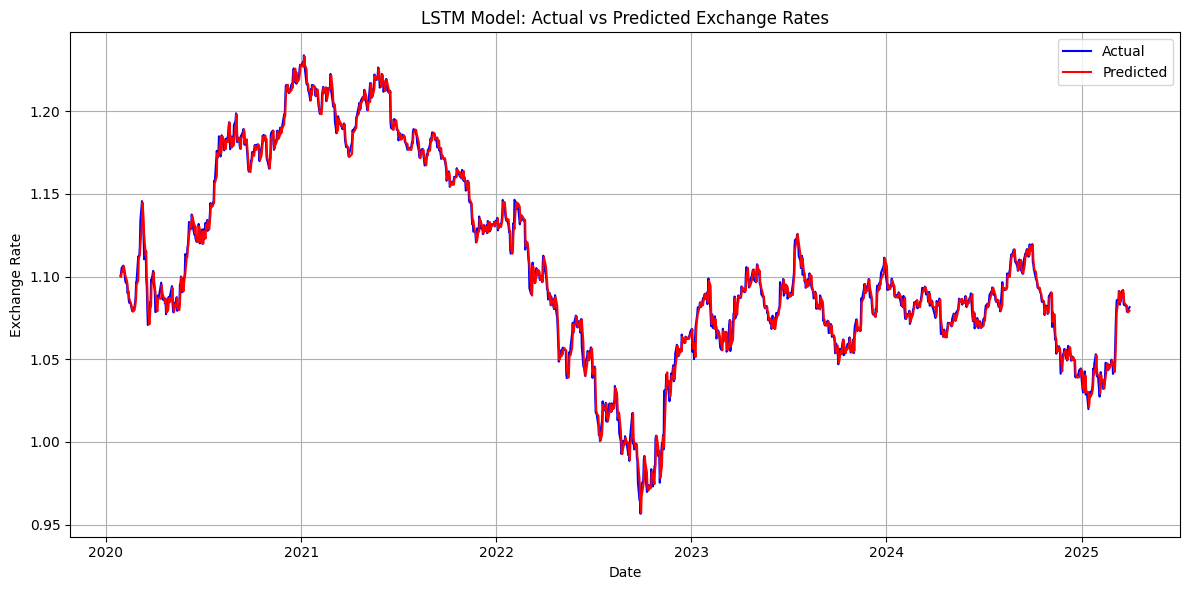

RMSE: 0.5752
MAE: 0.5750


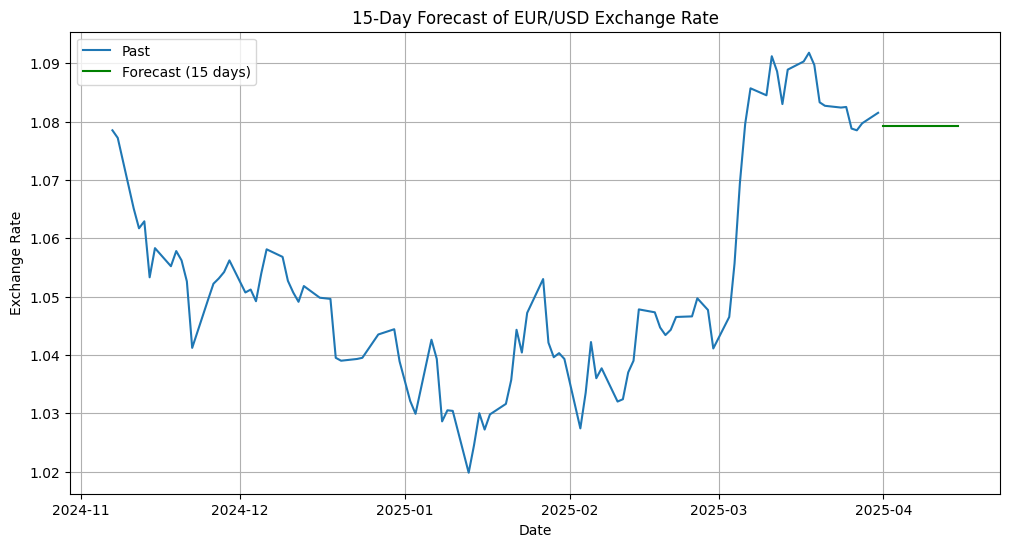

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Read Excel file
df = pd.read_excel('ECB_exchange_rates_march31.xlsx')  # Replace with the exact filename
print(df.columns)
# Renaming the column for EUR/USD exchange rate
#df = df.rename(columns={'USD': 'EUR/USD'})  # Adjust according to your dataset

# Set the 'Date' column as index and sort it
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')  # Make sure the date format matches your data
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Use the EUR/USD data column for training
data = df[['EUR/USD']].dropna()

# MinMax Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

# Create the dataset with a 90-day window size
window_size = 90
X, y = [], []

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, 0])  # Last 90 days as features
    y.append(scaled_data[i, 0])  # The value to predict (next day's exchange rate)

X, y = np.array(X), np.array(y)

# Reshaping X for LSTM: [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Splitting data into training and validation sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
optimizer = Adam()
model.compile(loss="mean_squared_error", optimizer=optimizer)

# Training the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=2, callbacks=[early_stopping])

# Save the model and scaler
model.save('eur_usd_lstm_model.keras')
joblib.dump(scaler, 'scaler.pkl')

# Plotting the loss curves
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Predicting and Inverse Scaling
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions)

# Get the correct index for validation
val_index = df.index[train_size + window_size: train_size + window_size + len(y_val)]

# Plotting actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(val_index, scaler.inverse_transform(y_val.reshape(-1, 1)), label='Actual', color='blue')
plt.plot(val_index, predictions, label='Predicted', color='red')
plt.title('LSTM Model: Actual vs Predicted Exchange Rates')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Calculate evaluation metrics
predicted_actual = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_val.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(actual, predicted_actual))
mae = mean_absolute_error(actual, predicted_actual)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Forecast future 15 days
forecast_input = X_val[-1]  # Shape: (window_size, 1)
forecast = []

for _ in range(15):
    next_pred = model.predict(forecast_input.reshape(1, window_size, 1), verbose=0)
    forecast.append(next_pred[0, 0])

# Update the input sequence by appending the new prediction and removing the oldest
next_step = np.array([[next_pred[0, 0]]])  # Shape: (1, 1)
forecast_input = np.vstack([forecast_input[1:], next_step])  # Shape stays (window_size, 1)

# Inverse transform the forecast to get real values
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Create forecast dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=15)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100:], df['EUR/USD'].values[-100:], label='Past')
plt.plot(future_dates, forecast, label='Forecast (15 days)', color='green')
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.title("15-Day Forecast of EUR/USD Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()